In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Masking

# Load dataset
data = pd.read_csv("../../dataset2001_2024.csv")

# Handle missing values
data.replace(-999.00, np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)

# Split data
train_data = data[data["YEAR"] <= 2022]
unlabeled_data = data[data["YEAR"] == 2023]

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(train_data.drop(columns=["T2M"]))
unlabeled_data_scaled = scaler.transform(unlabeled_data.drop(columns=["T2M"]))
y_train = train_data["T2M"].values

# Reshape data for LSTM
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
unlabeled_data_reshaped = unlabeled_data_scaled.reshape(unlabeled_data_scaled.shape[0], 1, unlabeled_data_scaled.shape[1])

# Define SSL model
inputs = Input(shape=(1, X_train.shape[1]))  # Shape: (timesteps=1, features)
masked = Masking(mask_value=0.0)(inputs)
x = LSTM(64)(masked)
outputs = Dense(X_train.shape[1])(x)  # Reconstruct all features

ssl_model = tf.keras.Model(inputs, outputs)
ssl_model.compile(optimizer="adam", loss="mse")

# Train SSL model on unlabeled data
ssl_model.fit(unlabeled_data_reshaped, unlabeled_data_scaled, epochs=10, batch_size=32)

# Extract encoder for fine-tuning
encoder = tf.keras.Model(inputs=ssl_model.input, outputs=ssl_model.layers[-2].output)

# Add a new head for T2M prediction
t2m_output = Dense(1)(encoder.output)
t2m_model = tf.keras.Model(inputs=encoder.input, outputs=t2m_output)
t2m_model.compile(optimizer="adam", loss="mse")

# Fine-tune on labeled data
t2m_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - loss: 0.7140
Epoch 2/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - loss: 0.0389
Epoch 3/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - loss: 0.0140
Epoch 4/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - loss: 0.0094
Epoch 5/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 0.0065
Epoch 6/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step - loss: 0.0052
Epoch 7/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - loss: 0.0040
Epoch 8/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 0.0035
Epoch 9/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 0.0027
Epoch 10/10
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - loss: 0.0023
Epoch 1/20
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 5s 774us/step - loss: 94.8241 - val_loss: 3.6889
Epoch 2/20
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 4s 748us/step - loss: 2.5851 - val_loss: 2.7940
Epoch 3/20
4821/4821 ━━━━━━━━━━━━━━━━━━━━ 4s 757us/step - loss: 1.9625 - val_loss: 2.5139
Epoch 4/20
4821/4821 ━━━━━━━━━━━━━━━━━

6027/6027 ━━━━━━━━━━━━━━━━━━━━ 3s 543us/step


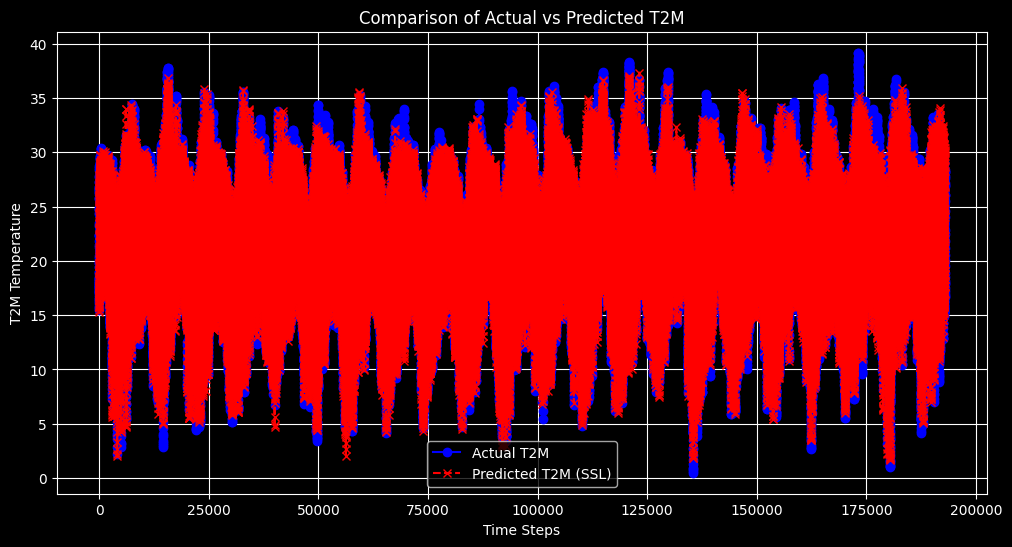

In [7]:
import matplotlib.pyplot as plt

# Predict T2M using the fine-tuned model
y_pred = t2m_model.predict(X_train_reshaped)

# Flatten the predictions (if necessary)
y_pred = y_pred.flatten()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_train, label="Actual T2M", color="blue", marker="o", linestyle="-")
plt.plot(y_pred, label="Predicted T2M (SSL)", color="red", marker="x", linestyle="--")
plt.title("Comparison of Actual vs Predicted T2M")
plt.xlabel("Time Steps")
plt.ylabel("T2M Temperature")
plt.legend()
plt.grid(True)
plt.show()